# Semantic Segmentation

*Follows general structure of [fast.ai notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import PIL

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Load Data

We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [4]:
path_data = Path('./data/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [5]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('data/bdd100k/seg/images/train/8eda31fc-dd1caf7e.jpg'),
 PosixPath('data/bdd100k/seg/images/train/61946360-00188770.jpg'),
 PosixPath('data/bdd100k/seg/images/train/3c1a9a7d-c44eeb32.jpg')]

In [6]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('data/bdd100k/seg/labels/train/81b47af4-08b8441f_train_id.png'),
 PosixPath('data/bdd100k/seg/labels/train/b53a1501-f21dfab8_train_id.png'),
 PosixPath('data/bdd100k/seg/labels/train/11d6859d-e1709fb8_train_id.png')]

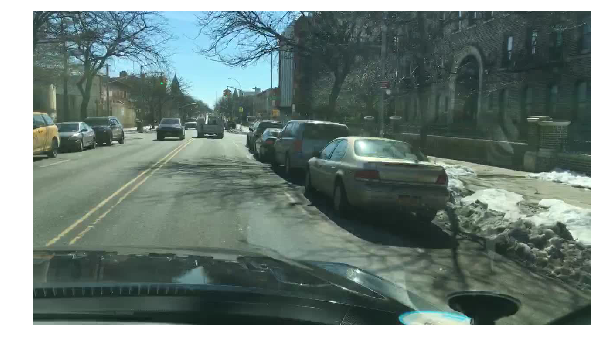

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [8]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

def change_void_val(x):
    # Change void value from 255 in the dataset to 19
    # for better visualization of segmentation map
    x = np.array(x)
    x[x==255] = 19
    return x

img_f, get_y_fn(img_f)

(PosixPath('data/bdd100k/seg/images/train/8eda31fc-dd1caf7e.jpg'),
 PosixPath('data/bdd100k/seg/labels/train/8eda31fc-dd1caf7e_train_id.png'))

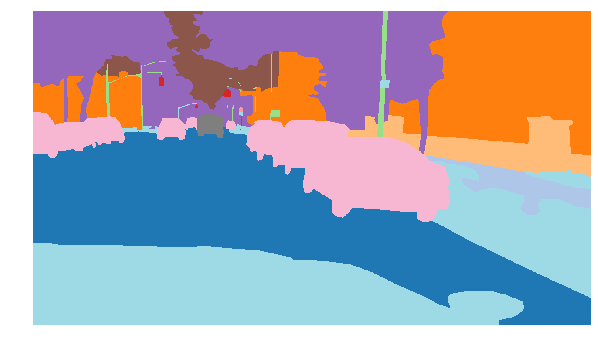

In [9]:
mask = open_mask(get_y_fn(img_f), after_open = change_void_val)
mask.show(figsize=(10,10), alpha=1)

In [38]:
# Process labels (255 value changed to 19)

#for lbl_name in lbl_names:
#    img = PIL.Image.open(lbl_name)
#    pixels = img.load()
#    for i in range(img.size[0]):
#        for j in range(img.size[1]):
#            if pixels[i,j] == 255:
#                pixels[i, j] = 19
#    img.save(lbl_name)

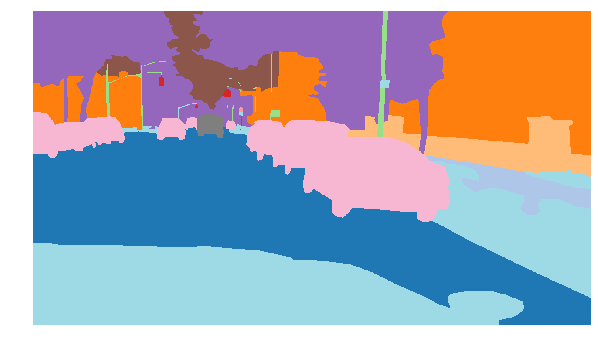

In [39]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [40]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[ 8,  8,  8,  ...,  2,  2,  2],
          [ 8,  8,  8,  ...,  2,  2,  2],
          [ 8,  8,  8,  ...,  2,  2,  2],
          ...,
          [19, 19, 19,  ...,  0,  0,  0],
          [19, 19, 19,  ...,  0,  0,  0],
          [19, 19, 19,  ...,  0,  0,  0]]]))

## Datasets

In [51]:
size = src_size // 2
bs = 4

In [52]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = ['road',
                       'sidewalk',
                       'building',
                       'wall',
                       'fence',
                       'pole',
                       'traffic light',
                       'traffic sign',
                       'vegetation',
                       'terrain',
                       'sky',
                       'person',
                       'rider',
                       'car',
                       'truck',
                       'bus',
                       'train',
                       'motorcycle',
                       'bicycle',
                        'void']

In [53]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes = segmentation_classes))

In [54]:
src

LabelLists;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: data/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: data/bdd100k/seg/images;

Test: None

In [55]:
def _change_void_val(x):
    x = np.array(x)
    x[x==255] = 10000
    return x

change_void_val = TfmPixel(_change_void_val)

In [56]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

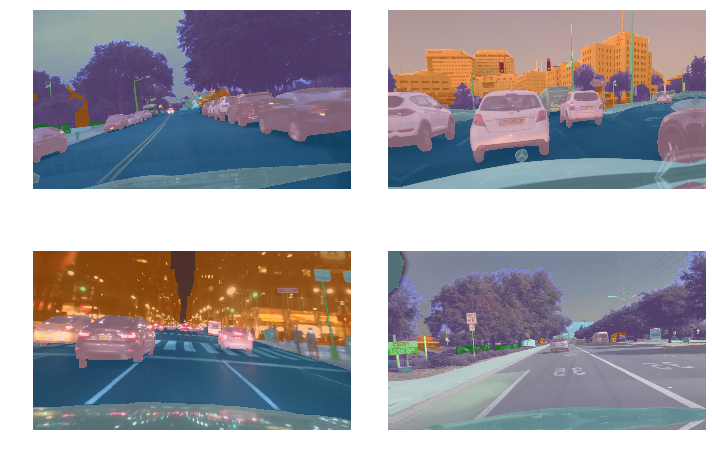

In [57]:
data.show_batch(2, figsize=(10,7))

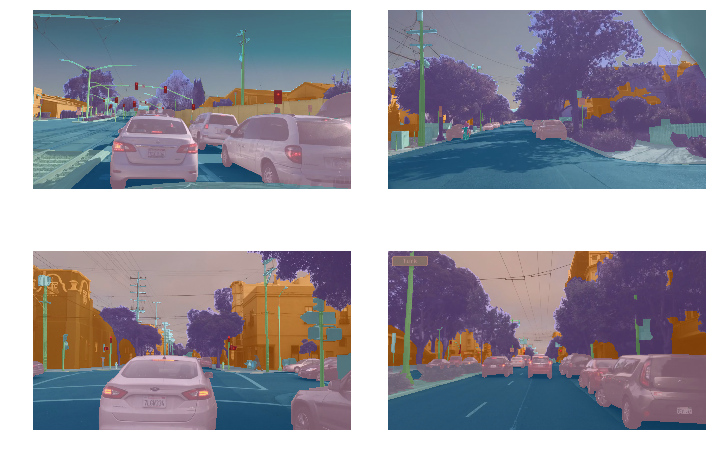

In [58]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [59]:
name2id = {v:k for k,v in enumerate(segmentation_classes)}
void_code = name2id['void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [60]:
metrics=acc_camvid
# metrics=accuracy

In [61]:
wd=1e-2

In [62]:
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

In [63]:
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 506.25 MiB (GPU 0; 2.95 GiB total capacity; 1.02 GiB already allocated; 522.88 MiB free; 23.32 MiB cached)

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin